In [1]:
import numpy as np
from openai import OpenAI
from collections import defaultdict
from tqdm import tqdm
from evaluate import load_data, parse_answer, check_answer_correctness, most_frequent_answer, judge_answers

In [2]:
agent_responses, dataset = load_data('results/mquake/adv_100_3_3_1/adv_mquake_100_3_3_1_3.jsonl')
n_samples = len(agent_responses)
n_agents = len(agent_responses[0]['agent_responses'])
n_turns = len(agent_responses[0]['agent_responses'][0])//2

In [3]:
from collections import Counter
if dataset == "math":
    levels = []
    for i in range(n_samples):
        level = agent_responses[i]['raw_task']['level']
        levels.append(level)

    cnt = Counter(levels)
    print(cnt)

In [4]:
agent_turn_correct = np.zeros((n_agents, n_turns))
agent_adversary = np.zeros(n_agents)
agent_agreement = np.zeros((n_agents, n_turns))
majority_vote = np.zeros(n_turns)
judge_vote = np.zeros(n_turns)
client = OpenAI()
for agent_response in tqdm(agent_responses):

        question = agent_response['question']
        gt = agent_response['answer']
        raw_task = agent_response['raw_task']
        agents_conv = agent_response['agent_responses']

        all_answers = defaultdict(list)
        for agent, agent_conv in enumerate(agents_conv):
            adversary = False
            for context in agent_conv:
                if context['role'] == 'system':
                    adversary = True
                    agent_adversary[agent] = 1

                if context['role'] == 'assistant':
                    tmp_answer = parse_answer(dataset, context['content'], raw_task)
                    all_answers[agent].append(tmp_answer)

         
        np_all_answers = np.array(list(all_answers.values()))
        # compute answer correctness per round/agent
        for agent in range(n_agents):
            answers = np_all_answers[agent]
            for turn in range(n_turns):
                ans = answers[turn]
                # print("agent: ", agent, " turn: ", turn, "answer: ", ans)
                agent_turn_correct[agent][turn] += check_answer_correctness(dataset, ans, gt)

        # compute agreement: # of agents that agree on the same answer
        for turn in range(n_turns):
            for agent in range(n_agents):
                agent_answer = np_all_answers[agent][turn]
                # get index of agents that have the same answer
                same_ans = np.where(np_all_answers[:, turn] == agent_answer)[0]
                # remove the current agent
                same_ans = same_ans[same_ans != agent]
                agent_agreement[agent][turn] += len(same_ans)

        # compute majority vote per round
        for turn in range(n_turns):
            answers = np_all_answers[:, turn].tolist()
            final_answer = most_frequent_answer(answers)
            majority_vote[turn] += check_answer_correctness(dataset, final_answer, gt)

        # compute judge vote per round
        # for turn in range(n_turns):
        #     answers = np_all_answers[:, turn].tolist()
        #     final_answer = judge_answers(answers, question, dataset, raw_task, client)
        #     judge_vote[turn] += check_answer_correctness(dataset, final_answer, gt)

        # print('Answers: ', answers, "final answer: ", final_answer, "gt: ",  gt, 'correct: ', check_answer_correctness(dataset, final_answer, gt))
                

 26%|██▌       | 26/100 [00:00<00:00, 6752.02it/s]


IndexError: list index out of range

In [9]:
tmp_answer = parse_answer(dataset, context['content'], raw_task)

IndexError: list index out of range

In [16]:
# Majortiy vote per turn
majority_vote = majority_vote/n_samples
print('Majority vote per turn')
for turn in range(n_turns):
    print(f'Turn {turn+1}: {majority_vote[turn]}')

Majority vote per turn
Turn 1: 0.52
Turn 2: 0.42
Turn 3: 0.47


In [17]:
# Accuracy per agent
for agent in range(len(agent_turn_correct)):
    print(f"Agent {agent} #total: ", agent_turn_correct[agent])
    print(f"Agent {agent} acc: ", agent_turn_correct[agent]/n_samples)

Agent 0 #total:  [47. 12. 11.]
Agent 0 acc:  [0.47 0.12 0.11]
Agent 1 #total:  [54. 53. 55.]
Agent 1 acc:  [0.54 0.53 0.55]
Agent 2 #total:  [51. 54. 55.]
Agent 2 acc:  [0.51 0.54 0.55]


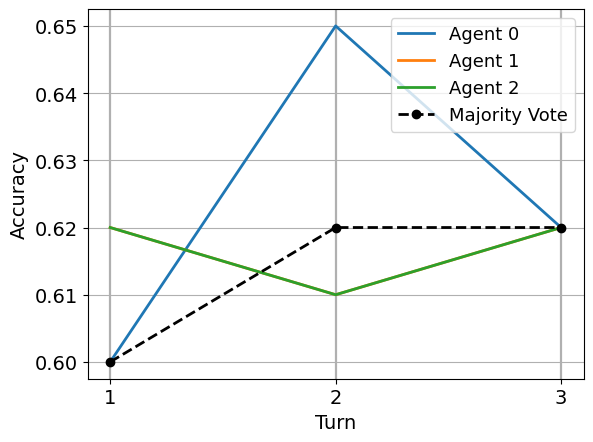

In [7]:
import matplotlib.pyplot as plt
rounds = range(1, n_turns+1)

for agent in range(len(agent_turn_correct)):
    if agent_adversary[agent] == 1:
        plt.plot(rounds, agent_turn_correct[agent]/n_samples, label=f'Agent {agent} (Adversary)', linestyle='--', marker='^', color='red', linewidth=2)
    else:
        plt.plot(rounds, agent_turn_correct[agent]/n_samples, label=f'Agent {agent}', linewidth=2)

plt.plot(rounds, majority_vote, label='Majority Vote', linestyle='--', marker='o', color='black', linewidth=2)

plt.xticks(rounds, fontsize=14)
plt.xlabel('Turn', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=13)
plt.grid(axis='x', linewidth=1.6)
plt.grid(axis='y')
plt.show()



In [18]:
# Agreement per agent

# ------------
#samples=1
# max_agreement = 2
# normalization = 2 / (#samples * #agents-1) = 2 / 1 * (3-1) = 1

# samples=2
# max_agreement = 4
# normalization = 4 / (#samples * #agents-1) = 4 / 2 * (3-1) = 1

# samples=3
# max_agreement = 6
# normalization = 6 / (#samples * #agents-1) = 6 / 3 * (3-1) = 1

# samples=4
# max_agreement = 8
# normalization = 8 / (#samples * #agents-1) = 8 / 4 * (3-1) = 1
# ------------

norm_agent_agreement = agent_agreement/(n_samples*(n_agents-1))
for agent in range(len(agent_agreement)):
    print(f"Agent {agent} agreement: ", norm_agent_agreement[agent])


Agent 0 agreement:  [0.67  0.085 0.12 ]
Agent 1 agreement:  [0.69 0.37 0.43]
Agent 2 agreement:  [0.72  0.385 0.43 ]


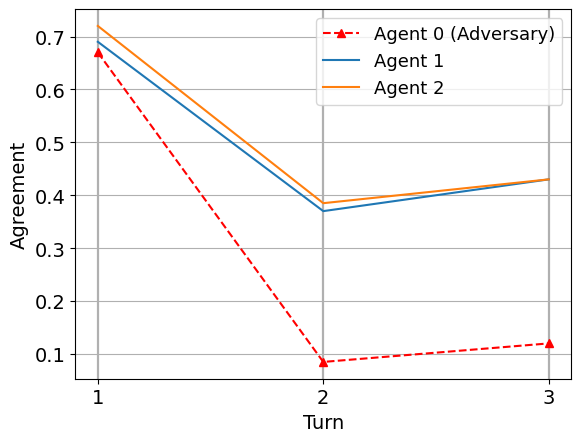

In [19]:
# plot normalized agreement
plt.figure()
for agent in range(len(agent_agreement)):
    if agent_adversary[agent] == 1:
        plt.plot(rounds, norm_agent_agreement[agent], label=f'Agent {agent} (Adversary)', linestyle='--', marker='^', color='red')
    else:
        plt.plot(rounds, norm_agent_agreement[agent], label=f'Agent {agent}')


plt.xticks(rounds, fontsize=14)
plt.xlabel('Turn', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Agreement', fontsize=14)
plt.legend(fontsize=13)
plt.grid(axis='x', linewidth=1.6)
plt.grid(axis='y')
plt.show()
